# Описание проекта

Построить модель для определения стоимости автомобиля по заданным характеристикам.    
Для оценки качества моделей использовать метрику RMSE.  

### Данные

В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

# План работы     
[1. Подготовка и исследование данных.](#1)      
[2. Обучение 3x моделей: LinearRegression, LightGBM, CatBoost. Подбор гипепараметров.](#2)      
[3. Анализ скорости работы и качества модели.](#3)      

### Библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

# graphics
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
# ML models
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

<a id='1'></a>
# 1. Подготовка данных

In [ ]:
data = read_csv('autos.csv')
data.info()
print("Dataset size:", data.shape)

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

пропуски есть только в категориальных признаках

<AxesSubplot:>

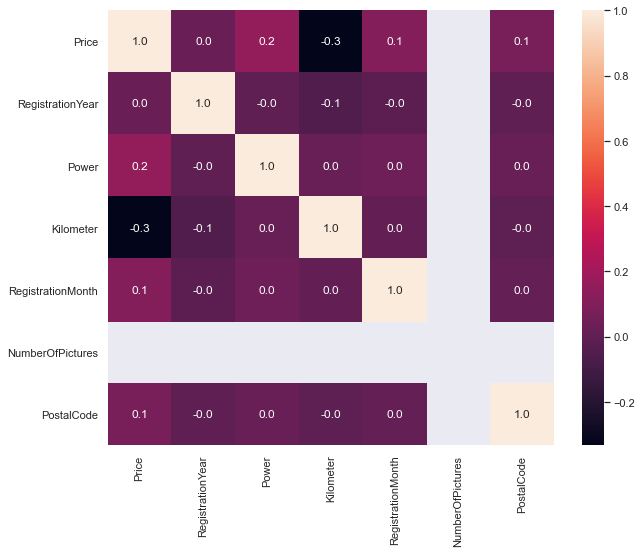

In [6]:
sns.set(rc={'figure.figsize': (10,8)})
sns.heatmap(data=data.corr(), annot=True, fmt='0.1f')

In [7]:
data['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

Удалим колонки которые не влияют на предсказание цены:
- DateCrawled, DateCreated, LastSeen, RegistrationMonth, PostalCode - не имеют отношения к описанию характеристики машины, поэтому не влияют на ценообразование
- NumberOfPictures - всегда 0
- Model ?

In [8]:
data = data.drop(['NumberOfPictures','DateCrawled', 'LastSeen', 'DateCreated', 'RegistrationMonth', 'PostalCode'], axis=1)

Заменим пропуски на 'na'

In [9]:
data = data.fillna('na')

Проверим данные на выбросы

In [10]:
columns = list(data.columns)

quantitative_columns = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

for i in quantitative_columns:
    columns.remove(i)
columns.remove('Model')

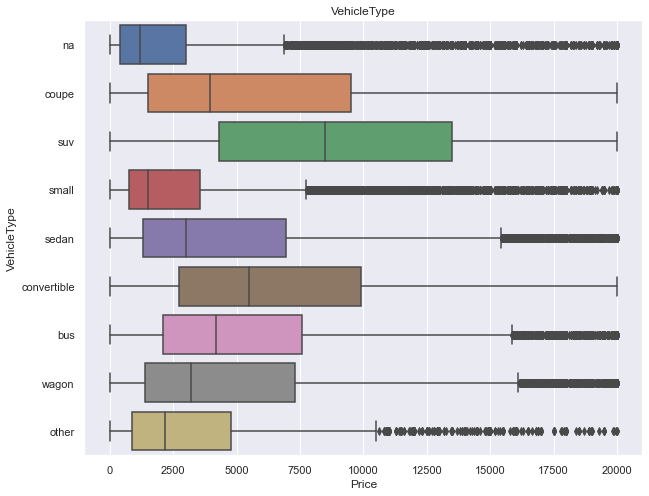

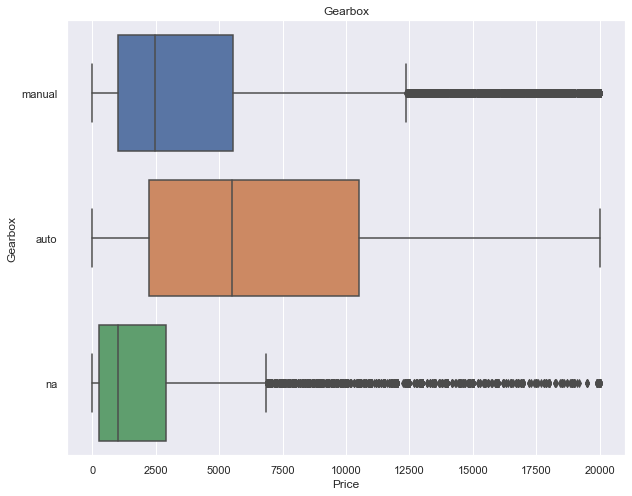

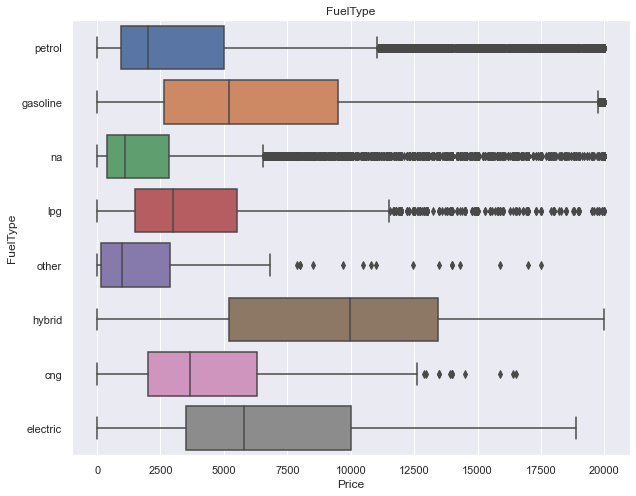

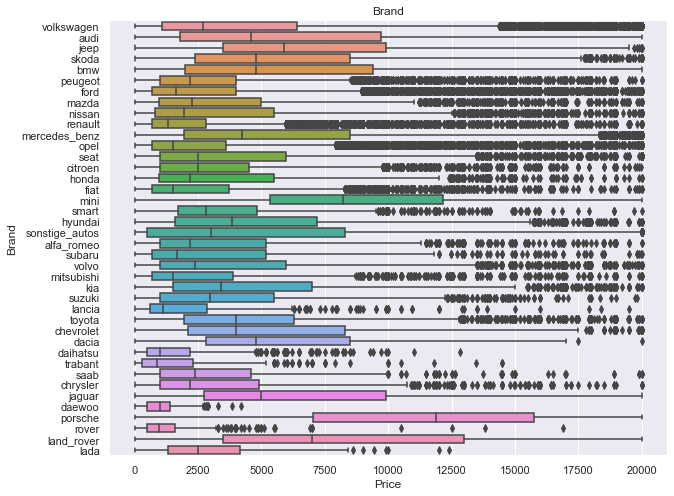

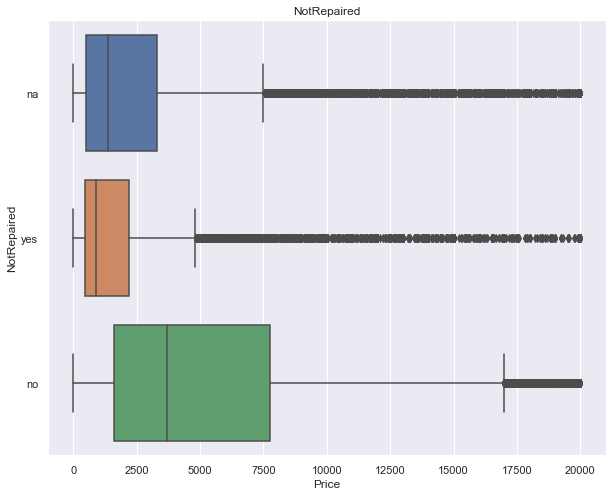

In [11]:
for i in columns:
    sns.boxplot(y=i, x='Price', data=data)
    plt.title(i)
    plt.show() 

пропуски в Gearbox можно заменить на механику, так как это минимальная комплектация

In [12]:
data['Gearbox'] = data['Gearbox'].where(data['Gearbox'] != 'na', 'manual')
data['Gearbox'].value_counts()

manual    288084
auto       66285
Name: Gearbox, dtype: int64

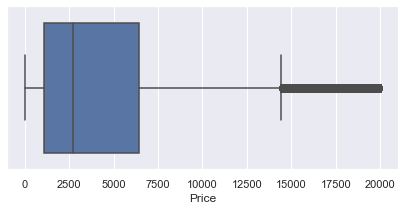

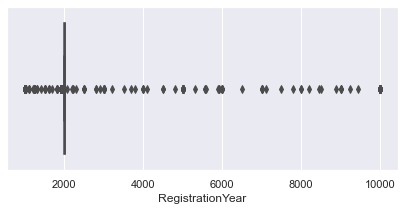

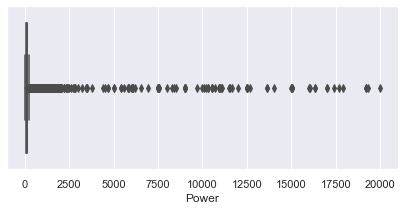

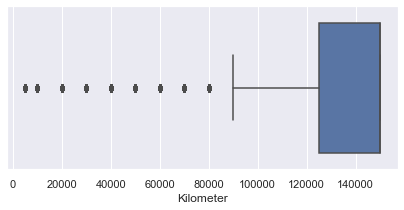

In [13]:
sns.set(rc={'figure.figsize':(7,3)})
for i in quantitative_columns:
    sns.boxplot(data[i])
    plt.show()

Удалим выбросы

1. год регистрации 1800-2020

In [14]:
data = data[(data['RegistrationYear'] > 1800)&(data['RegistrationYear'] < 2020)]
data['RegistrationYear'].count()

354198

2. максимальная мощность 1200 л.с.

In [15]:
data = data[(data['Power'] < 1200)]
data['Power'].count()

353947

In [16]:
data = data.reset_index().drop('index', axis=1)

<AxesSubplot:>

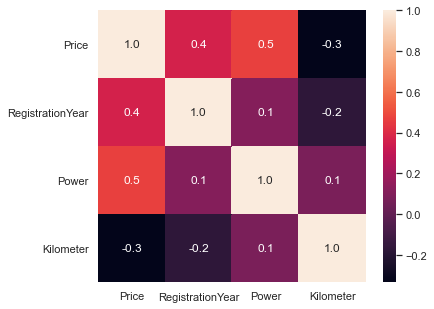

In [17]:
sns.set(rc={'figure.figsize': (6,5)})
sns.heatmap(data=data.corr(), annot=True, fmt='0.1f')

<a id='2'></a>
# 2. Обучение моделей

Попробуем обучить для сравнения три модели LinearRegression, CatBoost и Lightgbm. Подберем гиперпараметры, замерим время обучния модели при заданных гиперпараметрах и посчитаем RMSE. Результаты сохраним в словаре results

In [18]:
results = {
    'wall_time_fit': [],
    'wall_time_predict': [],
    'rmse': []
}

#### LinearRegression

1. преобразуем категориальные признаки с помошью OHE (этот метод лучше подходит для линейной регрессии)
2. разделим датасет на тренировочные и тестовые выборки
3. масштабируем количественные признаки

In [19]:
# transfoming categorical features using OHE
data_ohe = pd.get_dummies(data, drop_first=True)

# splitting data
features_train_reg, features_test_reg, target_train_reg, target_test_reg = train_test_split(
    data_ohe.drop('Price', axis=1), data.Price, test_size=0.25, random_state=12345)

# scaling features
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train_reg[numeric])

features_train_reg[numeric] = scaler.transform(features_train_reg[numeric])
features_test_reg[numeric] = scaler.transform(features_test_reg[numeric])
features_train_reg.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_na,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
232920,1.447299,-0.071926,-2.592211,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
37088,-1.997693,-0.256326,0.575100,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
314708,0.254802,-0.056559,0.575100,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
307279,-0.407696,0.527375,-0.084757,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
330900,-0.672696,-0.486826,0.575100,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


4. обучим модель линейной регрессии с помощью кросс-валидации, замерим время и RMSE

In [20]:
%%time
scores = cross_val_score(LinearRegression(), features_train_reg, target_train_reg, 
                              cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
-np.mean(scores)

CPU times: user 89.8 ms, sys: 134 ms, total: 223 ms
Wall time: 15.6 s


2808.318176623922

In [21]:
%%time
lin_model = LinearRegression()
lin_model.fit(features_train_reg, target_train_reg)

CPU times: user 13.5 s, sys: 619 ms, total: 14.2 s
Wall time: 4.53 s


LinearRegression()

In [22]:
%%time
lin_prediction = lin_model.predict(features_test_reg)
lin_rmse = mean_squared_error(target_test_reg, lin_prediction) ** 0.5
lin_rmse

CPU times: user 534 ms, sys: 74.3 ms, total: 608 ms
Wall time: 160 ms


2800.498907119709

In [23]:
results['rmse'].append(lin_rmse)
results['wall_time_fit'].append(4.97)
results['wall_time_predict'].append(176/1000)
results

{'wall_time_fit': [4.97],
 'wall_time_predict': [0.176],
 'rmse': [2800.498907119709]}

#### CatBoost

1. готовим выборки для обучения и тестирования и выделяем категориальные признаки

In [24]:
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired', 'Model']

features_train_boost, features_test_boost, target_train_boost, target_test_boost = train_test_split(
    data.drop('Price', axis=1), data.Price, test_size=0.25, random_state=12345)

2. Ищем лучшие гиперпараметры по сетке используя GridSearchCV

In [25]:
params = {
    'learning_rate':[0.1, 0.6],
    'depth':[2, 10],
    'l2_leaf_reg': [1, 9]
    
}

grid = GridSearchCV(CatBoostRegressor(loss_function="RMSE", iterations=200, silent=True),
                    param_grid=params,
                    cv=5,
                    scoring='neg_mean_squared_error',
                    verbose=False)

grid.fit(features_train_boost, target_train_boost, cat_features=cat_features)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x128df6d00>,
             param_grid={'depth': [2, 10], 'l2_leaf_reg': [1, 9],
                         'learning_rate': [0.1, 0.6]},
             scoring='neg_mean_squared_error', verbose=False)

In [26]:
grid.best_params_

{'depth': 10, 'l2_leaf_reg': 9, 'learning_rate': 0.6}

3. Обучаем модель c выбранными параметрами и замеряем время обучения, предсказания и RMSE

In [27]:
%%time
cat_model = CatBoostRegressor(loss_function="RMSE", iterations=200, 
                              learning_rate=0.6, depth=10, l2_leaf_reg=9, silent=True)

cat_model.fit(features_train_boost, target_train_boost, cat_features=cat_features)

CPU times: user 3min 27s, sys: 12.4 s, total: 3min 39s
Wall time: 30.5 s


In [28]:
%%time
cat_prediction = cat_model.predict(features_test_boost)
cat_rmse = mean_squared_error(target_test_boost, cat_prediction) ** 0.5
cat_rmse

CPU times: user 884 ms, sys: 29.9 ms, total: 914 ms
Wall time: 285 ms


1747.626618902668

In [29]:
results['rmse'].append(cat_rmse)
results['wall_time_fit'].append(28.2)
results['wall_time_predict'].append(254/1000)
results

{'wall_time_fit': [4.97, 28.2],
 'wall_time_predict': [0.176, 0.254],
 'rmse': [2800.498907119709, 1747.626618902668]}

#### LightGBM

1. данные берем такие же как для Catboost, но меняем тип категориальных данных на 'category'

In [30]:
features_train_boost[cat_features] = features_train_boost[cat_features].astype('category')
features_test_boost[cat_features] = features_test_boost[cat_features].astype('category')
features_test_boost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88487 entries, 53742 to 256409
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   VehicleType       88487 non-null  category
 1   RegistrationYear  88487 non-null  int64   
 2   Gearbox           88487 non-null  category
 3   Power             88487 non-null  int64   
 4   Model             88487 non-null  category
 5   Kilometer         88487 non-null  int64   
 6   FuelType          88487 non-null  category
 7   Brand             88487 non-null  category
 8   NotRepaired       88487 non-null  category
dtypes: category(6), int64(3)
memory usage: 3.3 MB


2. подбираем гиперпараметры

In [31]:
params = {
    'learning_rate': [0.1, 0.6],
    'max_depth': [3, 9],
    'num_leaves': [30, 90, 10],
    
}

grid = GridSearchCV(LGBMRegressor(random_state=333, num_iterations=200),
                    param_grid=params,
                    cv=5,
                    scoring='neg_mean_squared_error',
                    verbose=False)

grid.fit(features_train_boost, target_train_boost, categorical_feature=cat_features)

GridSearchCV(cv=5,
             estimator=LGBMRegressor(num_iterations=200, random_state=333),
             param_grid={'learning_rate': [0.1, 0.6], 'max_depth': [3, 9],
                         'num_leaves': [30, 90, 10]},
             scoring='neg_mean_squared_error', verbose=False)

In [32]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 90}

best parameters were: {'boost': 'dart', 'learning_rate': 0.6, 'max_depth': 9, 'num_leaves': 90}     
54.4 sec      
prediction 1717 rmse    

3.Обучаем модель c выбранными параметрами и замеряем время и RMSE

In [33]:
%%time
lgbm_model = LGBMRegressor(random_state=333, num_iterations=200, min_data_in_leaf=50, 
                           learning_rate=0.1, max_depth=9, num_leaves=90, boost='gbdt')

lgbm_model.fit(features_train_boost, target_train_boost, categorical_feature=cat_features)

CPU times: user 11.3 s, sys: 152 ms, total: 11.4 s
Wall time: 1.47 s


LGBMRegressor(boost='gbdt', max_depth=9, min_data_in_leaf=50,
              num_iterations=200, num_leaves=90, random_state=333)

In [34]:
%%time
prediction = lgbm_model.predict(features_test_boost)
lgbm_rmse = mean_squared_error(target_test_boost, prediction) ** 0.5

CPU times: user 3.26 s, sys: 32.3 ms, total: 3.29 s
Wall time: 439 ms


In [35]:
results['rmse'].append(lgbm_rmse)
results['wall_time_fit'].append(2.06)
results['wall_time_predict'].append(562/1000)
results

{'wall_time_fit': [4.97, 28.2, 2.06],
 'wall_time_predict': [0.176, 0.254, 0.562],
 'rmse': [2800.498907119709, 1747.626618902668, 1718.7513629226823]}

#### Константная модель

In [36]:
%%time
pred = np.ones(len(target_test_reg)) * target_train_reg.mean()
constant_rmse = mean_squared_error(target_test_reg, pred) ** 0.5
constant_rmse

CPU times: user 7.99 ms, sys: 2.22 ms, total: 10.2 ms
Wall time: 2.2 ms


4528.143994982386

In [37]:
results['rmse'].append(constant_rmse)
results['wall_time_fit'].append(0)
results['wall_time_predict'].append(0)
results

{'wall_time_fit': [4.97, 28.2, 2.06, 0],
 'wall_time_predict': [0.176, 0.254, 0.562, 0],
 'rmse': [2800.498907119709,
  1747.626618902668,
  1718.7513629226823,
  4528.143994982386]}

<a id='3'></a>
# 3. Анализ моделей

In [38]:
pd.DataFrame(results, index=['LinearRegression', 'CatBoost', 'LGBM', 'constant'])

,wall_time_fit,wall_time_predict,rmse
LinearRegression,4.97,0.176,2800.498907
CatBoost,28.20,0.254,1747.626619
LGBM,2.06,0.562,1718.751363
constant,0.00,0.000,4528.143995


Видно что CatBoost и LightGBM показывают почти схожую точность, но LightGBM чуть шустрее. 